In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
from moviepy.editor import VideoFileClip
import matplotlib.image as mpimg
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

In [2]:
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        #plt.imshow(img)
        #plt.show()

In [3]:
images = []
data_path = 'test_images/'
for file in os.listdir(data_path):
    image = mpimg.imread(data_path + file)
    images.append(image)
def visualise(do_process,num=len(images), show_gray=False):
    for image in images[0:num]:
        
        f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,15))
        ax1.set_title('Original')
        ax1.imshow(image)
        ax2.set_title('Processed')   
        image = do_process(image)
        if show_gray:
            ax2.imshow(image, 'gray')
        else:
            ax2.imshow(image)
        plt.show()

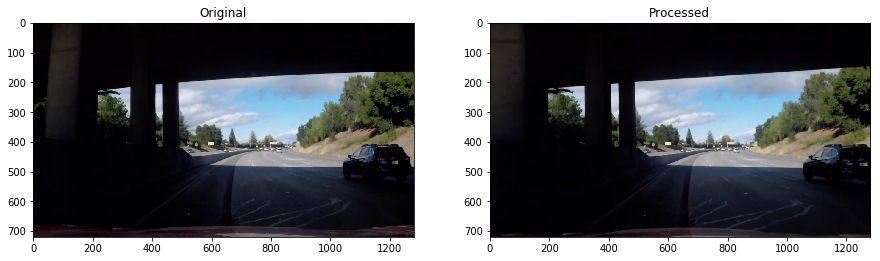

In [4]:
def undistort_image(image):
    img_size = (image.shape[1], image.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    return cv2.undistort(image, mtx, dist, None, mtx)
visualise(undistort_image,1)

In [5]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

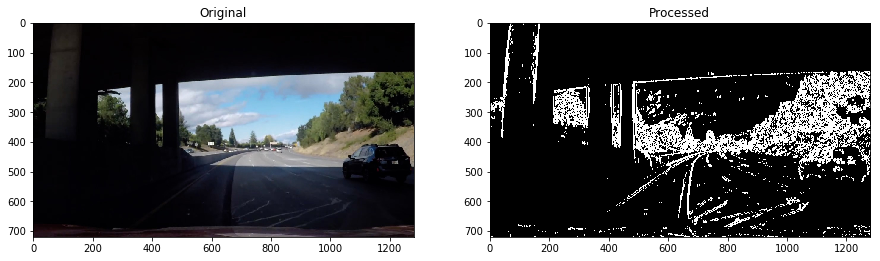

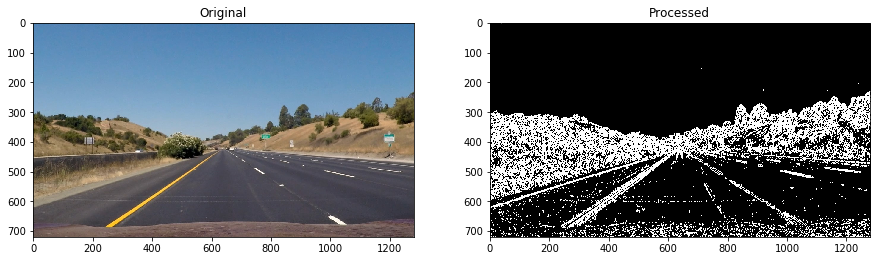

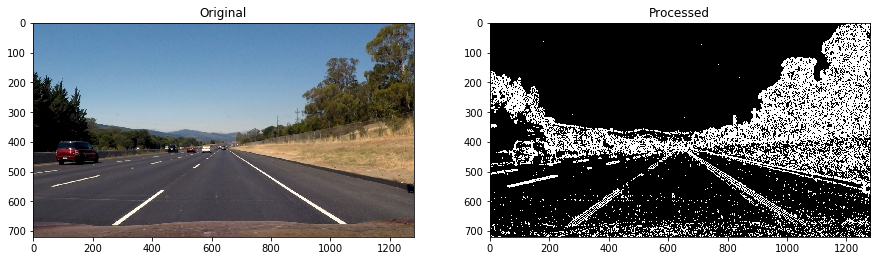

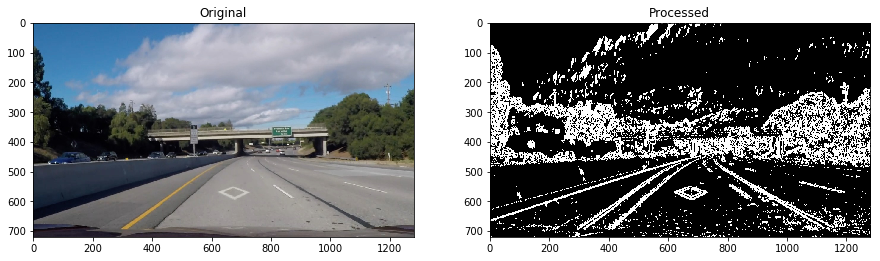

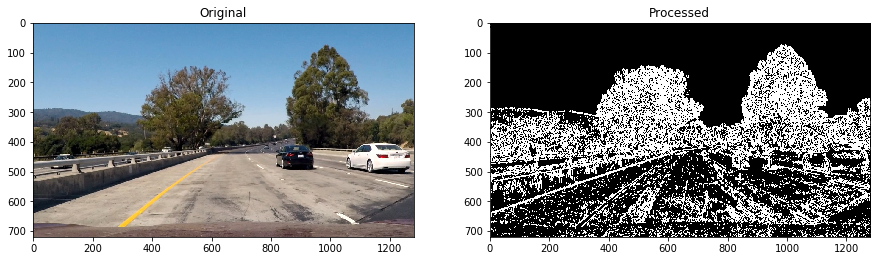

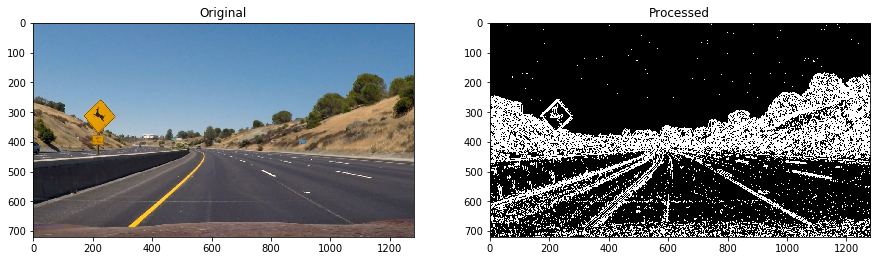

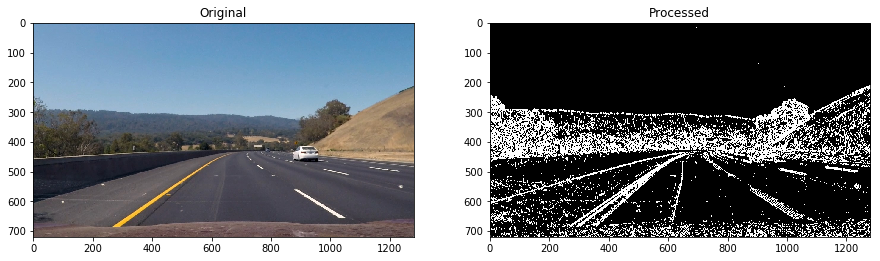

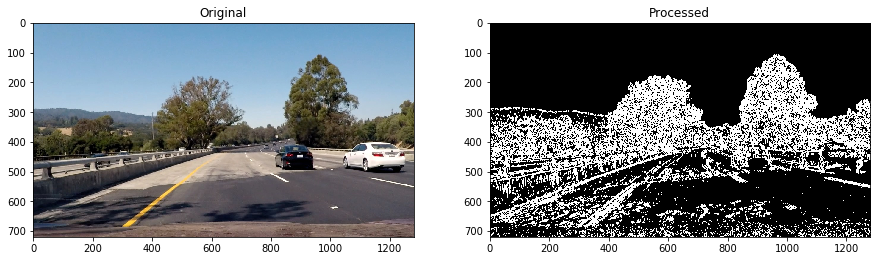

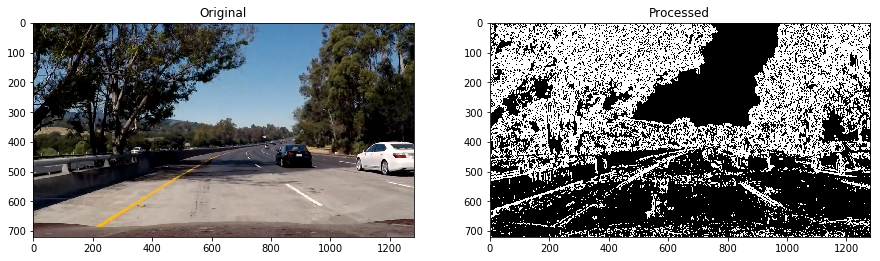

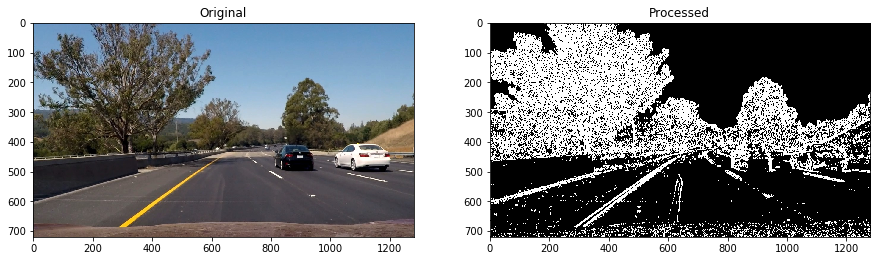

In [6]:
def combined_thresholds(image, ksize = 9):
    # Choose a Sobel kernel size

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(5, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(5, 100))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(5, 255))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(25*np.pi/180, 75*np.pi/180)) 
    combined = np.zeros_like(dir_binary, np.uint8)    
    combined[((gradx == 1) | (gradx == 1)) & ((mag_binary == 1) | (dir_binary == 1))] = 1
    return combined
#binn = combined_thresholds(images[2])
#plt.imshow(binn)
visualise(combined_thresholds,show_gray=True)

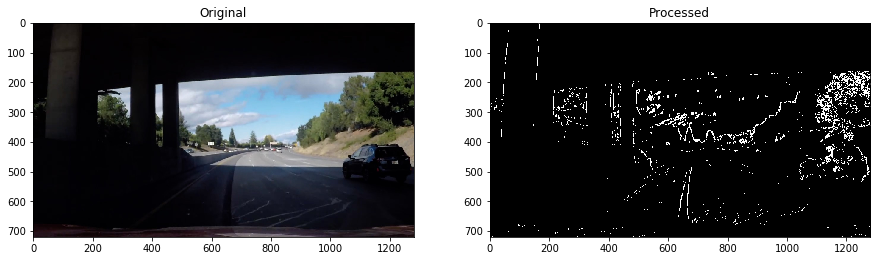

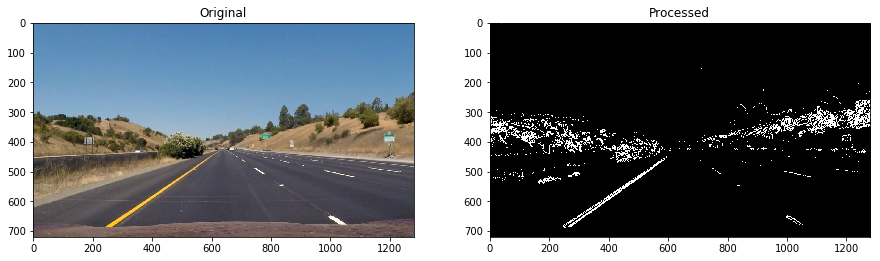

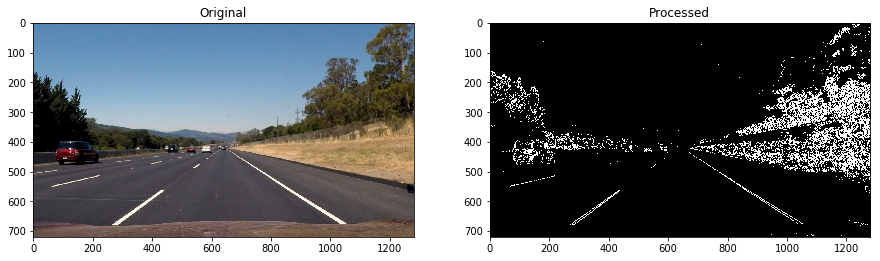

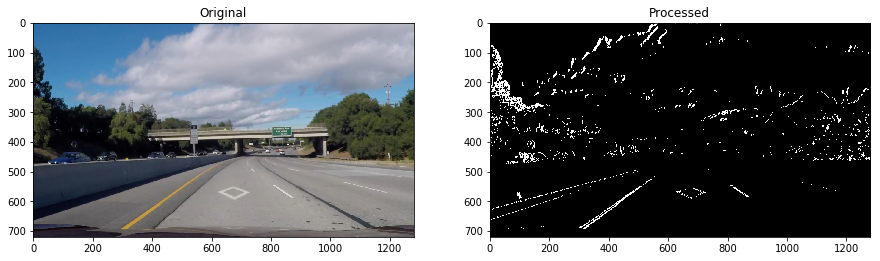

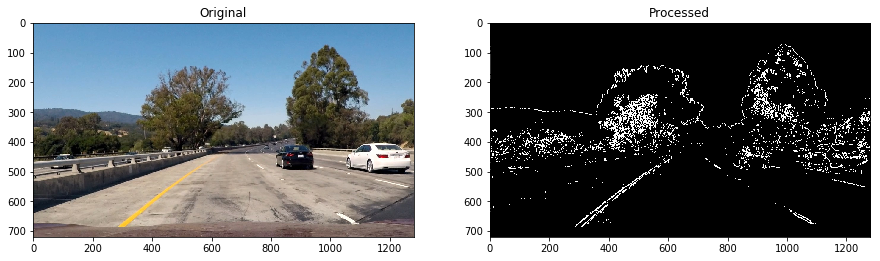

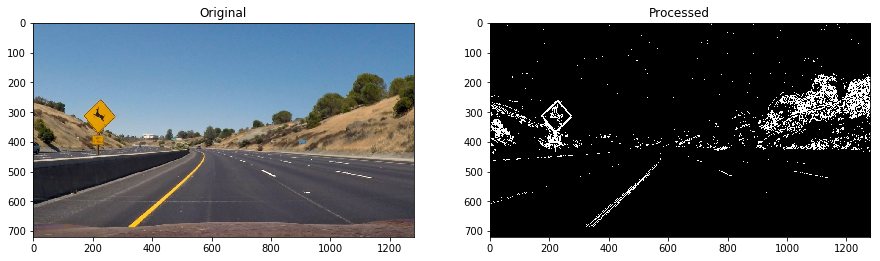

In [7]:
def filter(image):
    
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]

    sxbinary = combined_thresholds(image)


    # Threshold color channel
    h_thresh_min = 20
    h_thresh_max = 50
    s_thresh_min = 80
    s_thresh_max = 255
    l_thresh_min = 195
    l_thresh_max = 255  
    
#     s_binary = np.zeros_like(s_channel)
#     s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1      
#     plt.imshow(s_binary, 'gray')
#     plt.show()
    
    
    s_binary = np.zeros_like(s_channel)
    s_binary[((s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)) ] = 1
    
    l_binary = np.zeros_like(s_channel)
    l_binary[((l_channel >= l_thresh_min) & (l_channel <= l_thresh_max))] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[((s_binary == 1) & (sxbinary == 1)) | ((sxbinary == 1) & (l_binary == 1))] = 1
    
    return combined_binary

#binn = filter(images[3])
#plt.imshow(binn, 'gray')
#plt.show()
#plt.imshow(images[3])
visualise(filter,6, True)

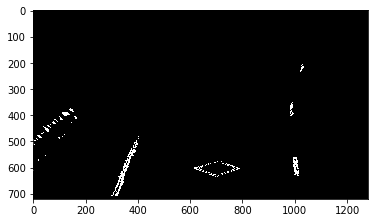

In [8]:
def warp(image):
    src = np.float32([[570,460],[image.shape[1] - 573,460],[image.shape[1] - 150,image.shape[0]],[150,image.shape[0]]])
    dst = np.float32([[200,0],[image.shape[1]-200,0],[image.shape[1]-200,image.shape[0]],[200,image.shape[0]]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, (image.shape[1],image.shape[0]), flags=cv2.INTER_LINEAR)
    return warped

def inwarp(image):
    src = np.float32([[570,460],[image.shape[1] - 573,460],[image.shape[1] - 150,image.shape[0]],[150,image.shape[0]]])
    dst = np.float32([[200,0],[image.shape[1]-200,0],[image.shape[1]-200,image.shape[0]],[200,image.shape[0]]])
    M = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(image, M, (image.shape[1],image.shape[0]), flags=cv2.INTER_LINEAR)
    return warped

binn = filter(images[3])
binnn = warp(binn)
plt.imshow(binnn, 'gray')

In [30]:
class LaneDetector:
    
    def __init__(self):
        self.detected = True
        self.left_lane_inds = []  # Create empty lists to receive left and right lane pixel indices
        self.right_lane_inds = []
        
        self.n_frames = 10
        
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = [np.zeros_like(720, np.float32), np.zeros_like(720, np.float32)]
        
        # coefficient values of the last n fits of the line
        self.recent_coefficients = []
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = [0,0,0]

    def draw_lane(self, orignal_image, binary_warped, filtered_binary):    
        
        nonzero = binary_warped.nonzero()  # Identify the x and y positions of all nonzero pixels in the image
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
         
        margin = 80   # Set minimum number of pixels found to recenter window   
        minpix = 50
        
        if self.detected:
            # Take a histogram of the bottom half of the image
            histogram = np.sum(binary_warped[binary_warped.shape[0] - 500:,:], axis=0)

            # Find the peak of the left and right halves of the histogram
            # These will be the starting point for the left and right lines
            midpoint = np.int(histogram.shape[0]/2)
            leftx_base = np.argmax(histogram[:midpoint])
            rightx_base = np.argmax(histogram[midpoint:]) + midpoint

            nwindows = 9  # Choose the number of sliding windows
            window_height = np.int((binary_warped.shape[0])/nwindows)   # Set height of windows

            leftx_current = leftx_base   # Current positions to be updated for each window
            rightx_current = rightx_base   # Set the width of the windows +/- margin
            
            left_lane_inds = []
            right_lane_inds = []

            # Step through the windows one by one
            for window in range(nwindows):

                # Identify window boundaries in x and y (and right and left)
                win_y_low = binary_warped.shape[0] - (window+1)*window_height
                win_y_high = binary_warped.shape[0] - window*window_height
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin

                # Draw the windows on the visualization image
                cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2) 
                cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2) 

                # Identify the nonzero pixels in x and y within the window
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                                  (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                                   (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            
                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)
                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            # Concatenate the arrays of indices
            self.left_lane_inds = np.concatenate(left_lane_inds)
            self.right_lane_inds = np.concatenate(right_lane_inds)
        else:
            self.left_lane_inds = ((nonzerox > (self.best_fit[0][0]*(nonzeroy**2) + self.best_fit[0][1]*nonzeroy + 
                                    self.best_fit[0][2] - margin)) & (nonzerox < (self.best_fit[0][0]*(nonzeroy**2) + 
                                    self.best_fit[0][1]*nonzeroy + self.best_fit[0][2] + margin))) 
            self.right_lane_inds = ((nonzerox > (self.best_fit[1][0]*(nonzeroy**2) + self.best_fit[1][1]*nonzeroy + 
                                    self.best_fit[1][2] - margin)) & (nonzerox < (self.best_fit[1][0]*(nonzeroy**2) + 
                                    self.best_fit[1][1]*nonzeroy + self.best_fit[1][2] + margin)))
        
        
        # Again, extract left and right line pixel positions
        leftx = nonzerox[self.left_lane_inds]
        lefty = nonzeroy[self.left_lane_inds] 
        rightx = nonzerox[self.right_lane_inds]
        righty = nonzeroy[self.right_lane_inds]

    
        # Fit a second order polynomial to each
        if lefty.shape[0] >= 70 and righty.shape[0] >= 300 and leftx.shape[0] >= 300 and rightx.shape[0] >= 300:
            self.detected = False
            self.left_fit = np.polyfit(lefty, leftx, 2)
            self.right_fit = np.polyfit(righty, rightx, 2)
        else:
            self.detected = True
            
        
        if len(self.recent_coefficients) >= self.n_frames:
            self.recent_coefficients.pop(0)
        self.recent_coefficients.append([self.left_fit, self.right_fit])
        
        self.best_fit = [0,0,0]
        for coefficient in self.recent_coefficients:
            self.best_fit[0] = self.best_fit[0] + coefficient[0]
            self.best_fit[1] = self.best_fit[1] + coefficient[1]
        
        self.best_fit[0] = self.best_fit[0]/len(self.recent_coefficients)
        self.best_fit[1] = self.best_fit[1]/len(self.recent_coefficients)
        
    
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = self.best_fit[0][0]*ploty**2 + self.best_fit[0][1]*ploty + self.best_fit[0][2]
        right_fitx = self.best_fit[1][0]*ploty**2 + self.best_fit[1][1]*ploty + self.best_fit[1][2]
        
        if len(self.recent_xfitted) >= self.n_frames:
            self.recent_xfitted.pop(0)
            

        self.recent_xfitted.append([left_fitx, right_fitx])
        

        self.bestx = [np.zeros_like(720, np.float32), np.zeros_like(720, np.float32)]
        for fit in self.recent_xfitted:
            self.bestx[0] = self.bestx[0] + fit[0]
            self.bestx[1] = self.bestx[1] + fit[1]
            
        self.bestx[0] = self.bestx[0]/len(self.recent_xfitted)
        self.bestx[1] = self.bestx[1]/len(self.recent_xfitted)
        
        
        
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        
        
#         plt.imshow(out_img)
#         plt.plot(left_fitx, ploty, color='yellow')
#         plt.plot(right_fitx, ploty, color='yellow')
#         plt.show()
        
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[self.left_lane_inds], nonzerox[self.left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[self.right_lane_inds], nonzerox[self.right_lane_inds]] = [0, 0, 255]
        

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        margin = 8
        left_line_window1 = np.array([np.transpose(np.vstack([self.bestx[0]-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([self.bestx[0]+margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))

        right_line_window1 = np.array([np.transpose(np.vstack([self.bestx[1]-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([self.bestx[1]+margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))


        center_line_window1 = np.array([np.transpose(np.vstack([self.bestx[0]+margin, ploty]))])
        center_line_window2 = np.array([np.flipud(np.transpose(np.vstack([self.bestx[1]-margin, ploty])))])
        center_line_pts = np.hstack((center_line_window1,center_line_window2))


        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (255,0, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (255,0, 0))
        cv2.fillPoly(window_img, np.int_([center_line_pts]), (0,255, 0))

        window_img_unwrapped = inwarp(window_img)

        result = cv2.addWeighted(orignal_image, 1, window_img_unwrapped, 0.3, 0)
        cv2.circle(result,(orignal_image.shape[1] - 100, 100), 30, (0,255,0), -1)
        #result = np.vstack((np.hstack((result, out_with_square)), np.hstack((orignal_image, np.dstack((filtered_binary, filtered_binary, filtered_binary))*255))))

    #    leftx = np.array([leftx[i] for i ,_ in enumerate(ploty)])
    #    rightx = np.array([rightx[i] for i,_ in enumerate(ploty)])

    #    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    #    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

        # Fit a second order polynomial to pixel positions in each fake lane line
    # left_fit = np.polyfit(ploty, leftx, 2)
    # left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    # right_fit = np.polyfit(ploty, rightx, 2)
    # right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Define y-value where we want radius of curvature
        # I'll choose the maximum y-value, corresponding to the bottom of the image
    #    y_eval = np.max(ploty)
    #    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    #    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

        # Define conversions in x and y from pixels space to meters
    #    ym_per_pix = 3.7/binary_warped.shape[0] # meters per pixel in y dimension
    #    xm_per_pix = 3.7/binary_warped.shape[1] # meters per pixel in x dimension


        # Fit new polynomials to x,y in world space
    #    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    #    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
    #    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    #    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    #    avg_curverad = (left_curverad + right_curverad) / 2
        # Now our radius of curvature is in meters
    #    cv2.putText(result, 'Radius of Curvature = ' + str(int(np.round(avg_curverad))) + '(m)', (30,80), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2)
    #    cv2.putText(result, 'Hello', (30,140), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2)


        #plt.imshow(result)
        #plt.plot(left_fitx, ploty, color='yellow')
        #plt.plot(right_fitx, ploty, color='yellow')
        #plt.xlim(0, 1280)
        #plt.ylim(720, 0)
        
        return result


me


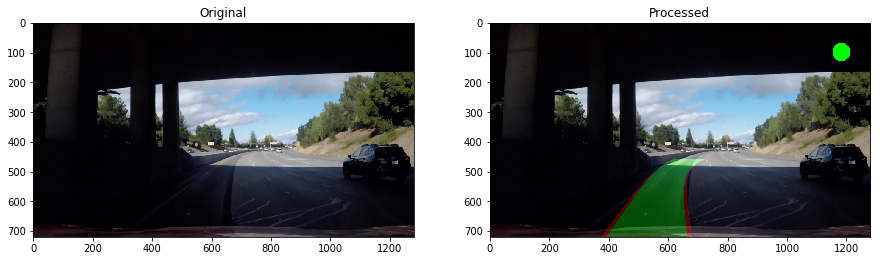

me


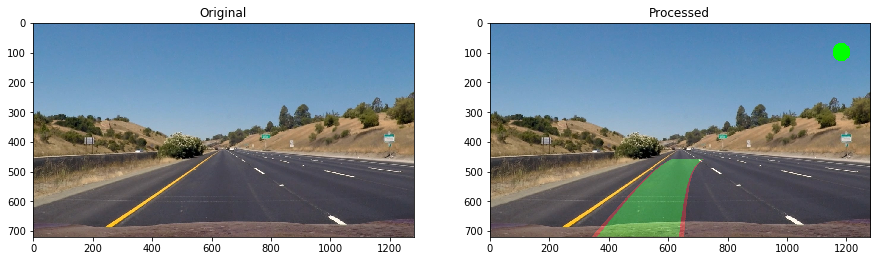

me


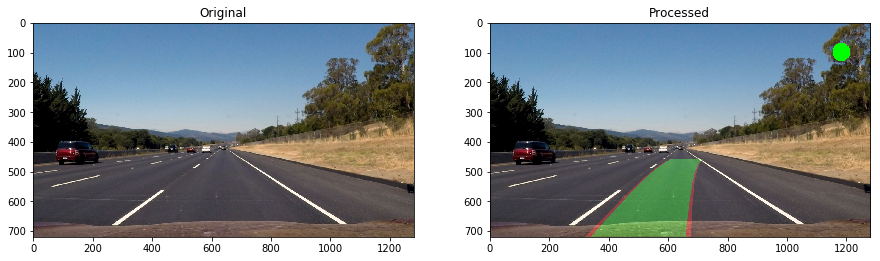

me


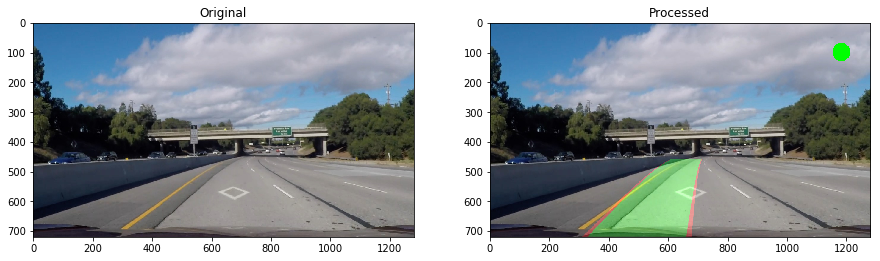

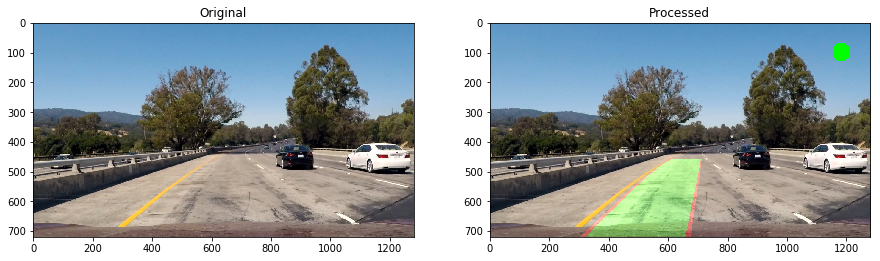

me


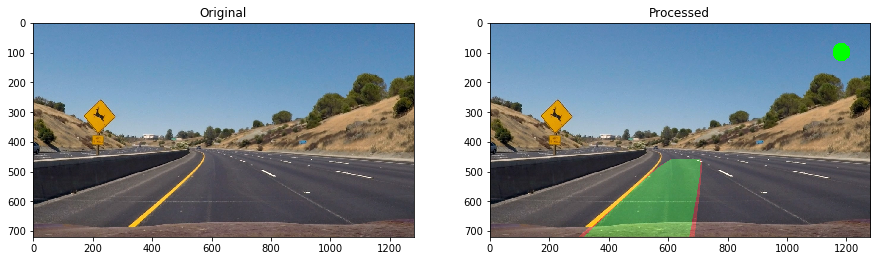

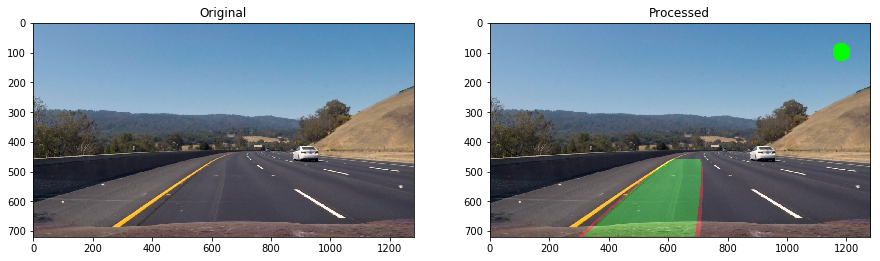

me


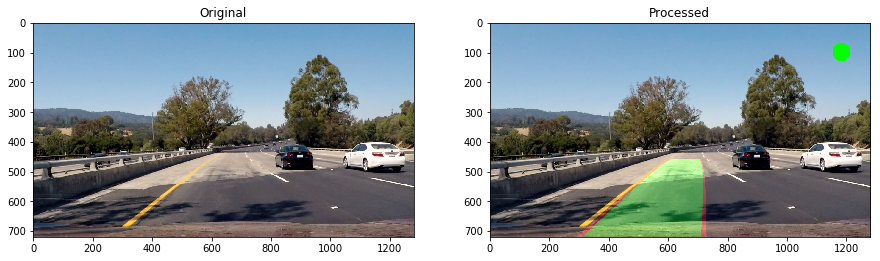

me


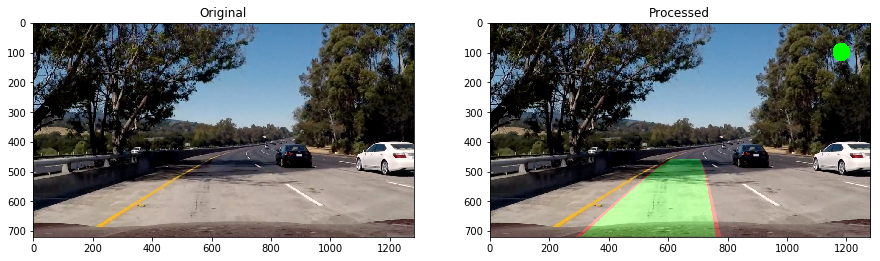

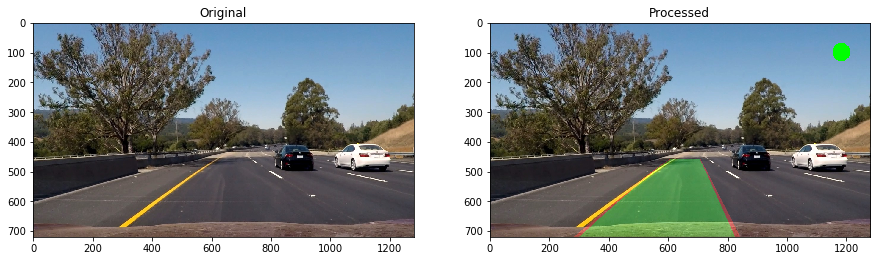

In [29]:
lane_detector = LaneDetector()
draw_lane = lane_detector.draw_lane
def process_image(image):
    undistorted = undistort_image(image)
    filtered_binary = filter(undistorted)
    binary_warped = warp(filtered_binary)
    final_image = draw_lane(image, binary_warped, filtered_binary)
    #final_image = detect_lane_lines(binary_warped)
    return final_image

visualise(process_image)

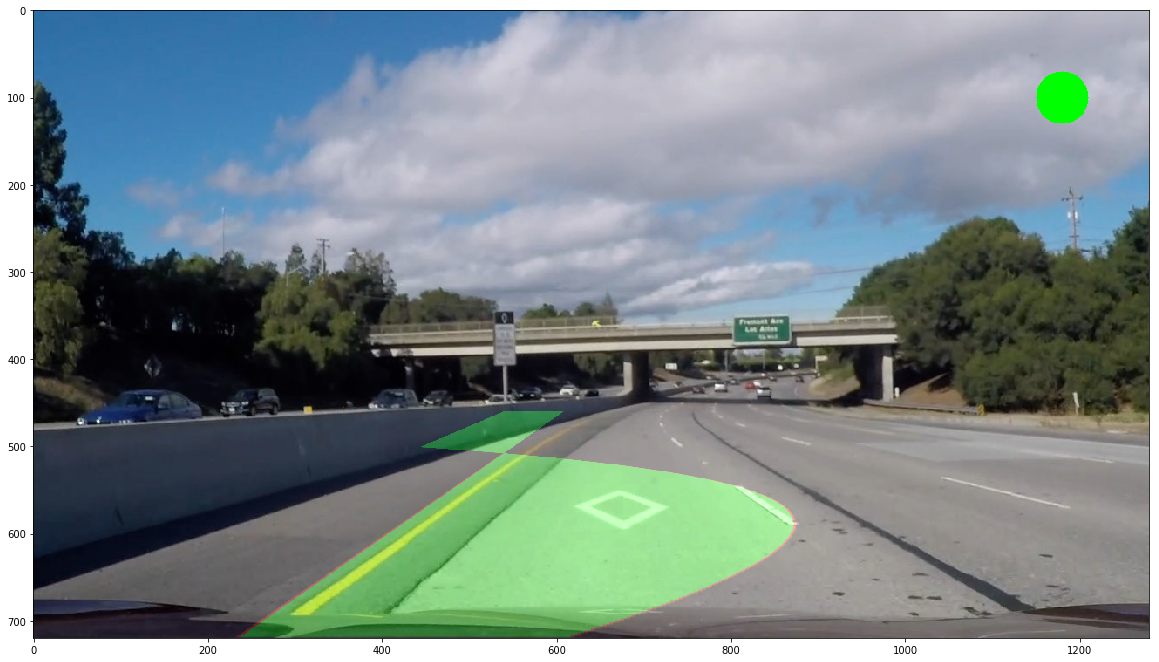

In [1784]:
test_image = mpimg.imread('test_images/test0.jpg')
final_image = process_image(test_image)
plt.figure(figsize=(20,20))
plt.imshow(final_image)

In [34]:
lane_detector = LaneDetector()
draw_lane = lane_detector.draw_lane
white_output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4



 12%|█▏        | 152/1261 [03:52<26:42,  1.45s/it]


 24%|██▍       | 303/1261 [07:40<24:13,  1.52s/it]


 36%|███▌      | 454/1261 [11:13<18:06,  1.35s/it]


 48%|████▊     | 605/1261 [14:49<13:52,  1.27s/it]


 60%|█████▉    | 756/1261 [18:24<12:00,  1.43s/it]


 72%|███████▏  | 907/1261 [22:07<07:43,  1.31s/it]


 84%|████████▍ | 1057/1261 [25:42<04:43,  1.39s/it]


 96%|█████████▌| 1205/1261 [29:17<01:16,  1.37s/it]


100%|█████████▉| 1260/1261 [30:35<00:01,  1.51s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 18min 34s, sys: 1min 36s, total: 20min 10s
Wall time: 30min 36s


In [31]:
lane_detector = LaneDetector()
draw_lane = lane_detector.draw_lane
white_output = 'challenge_video_out.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video challenge_video_out.mp4
[MoviePy] Writing video challenge_video_out.mp4



 32%|███▏      | 155/485 [03:42<08:51,  1.61s/it]


 64%|██████▎   | 309/485 [07:19<04:23,  1.50s/it]


 95%|█████████▌| 463/485 [11:01<00:29,  1.34s/it]


100%|██████████| 485/485 [11:34<00:00,  1.44s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_out.mp4 

CPU times: user 7min 5s, sys: 32 s, total: 7min 37s
Wall time: 11min 35s


In [35]:
lane_detector = LaneDetector()
draw_lane = lane_detector.draw_lane
white_output = 'harder_challenge_video_out.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_out.mp4
[MoviePy] Writing video harder_challenge_video_out.mp4



 13%|█▎        | 152/1200 [03:41<24:55,  1.43s/it]


 25%|██▌       | 303/1200 [07:21<22:56,  1.54s/it]


 38%|███▊      | 454/1200 [10:57<18:18,  1.47s/it]


 50%|█████     | 605/1200 [14:34<14:38,  1.48s/it]


 63%|██████▎   | 756/1200 [18:12<10:20,  1.40s/it]


 76%|███████▌  | 907/1200 [22:07<14:43,  3.01s/it]


 88%|████████▊ | 1057/1200 [26:05<03:28,  1.46s/it]


100%|█████████▉| 1199/1200 [29:30<00:01,  1.64s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_out.mp4 

CPU times: user 17min 46s, sys: 1min 27s, total: 19min 14s
Wall time: 29min 31s
